In [1]:
!python3 prepare_dataset.py

Preparing waste classification dataset from: /home/x/Desktop/cv2/waste_classification/
Found 4 classes: Glass, Metal, Paper, Plastic
  Class Glass: 750 default images, 750 real-world images
  Class Metal: 1000 default images, 1000 real-world images
  Class Paper: 1250 default images, 1250 real-world images
  Class Plastic: 2250 default images, 2250 real-world images

Dataset split complete:
  Training: 7350 images
  Validation: 1575 images
  Test: 1575 images
Dataset files written to ./labels


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.utils import shuffle
import time
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Pipeline
from utils import load_dataset, visualize_results, save_model, ModelEvaluator
from preprocessing import ImagePreprocessor
from feature_extraction import FeatureExtractor
from classification import CustomClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

np.random.seed(42)
tf.random.set_seed(42)

print("devices:", tf.config.list_physical_devices())
print("Is GPU available:", tf.config.list_physical_devices('GPU'))
print("Using CPU for computation")

print("Starting Waste Classification Project Pipeline:")
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())}")


In [ ]:
print("\n[1] Loading dataset...")
dataset_path = "/home/x/Desktop/cv2/waste_classification/"
dataset = load_dataset(dataset_path)

if dataset is None:
    print("Error loading dataset. Exiting.")
    raise ValueError("Dataset could not be loaded")

categories = dataset['categories']
print(f"Categories: {categories}")
print(f"Number of training samples: {len(dataset['train_data'])}")
print(f"Number of validation samples: {len(dataset['val_data'])}")
print(f"Number of test samples: {len(dataset['test_data'])}")

In [ ]:
def analyze_class_distribution(labels, name, categories):
    counts = np.zeros(len(categories), dtype=int)
    for label in labels:
        counts[label] += 1
    
    print(f"\n{name} class distribution:")
    for i, count in enumerate(counts):
        print(f"  Class {categories[i]}: {count} samples ({count/len(labels)*100:.1f}%)")
    return counts

train_counts = analyze_class_distribution(dataset['train_labels'], "Training", categories)
val_counts = analyze_class_distribution(dataset['val_labels'], "Validation", categories)
test_counts = analyze_class_distribution(dataset['test_labels'], "Test", categories)

train_data = dataset['train_data']
train_labels = dataset['train_labels']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
test_data = dataset['test_data']
test_labels = dataset['test_labels']

print(f"\nFinal dataset sizes:")
print(f"  Training: {len(train_data)} samples")
print(f"  Validation: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(categories, train_counts, color='skyblue')
plt.title('Training Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
plt.bar(categories, test_counts, color='lightgreen')
plt.title('Test Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nWarning: Processing the full dataset on CPU may take a significant amount of time.")
print("Starting preprocessing with material-specific augmentations...")

NameError: name 'dataset' is not defined

In [ ]:
print("\n[2] Applying enhanced preprocessing...")

preprocessor = ImagePreprocessor(
    target_size=(224, 224), 
    apply_augmentation=True
)

batch_size = 1500

def process_in_batches(data_list, with_augmentation=False, desc="Processing"):
    preprocessor.apply_augmentation = with_augmentation
    all_processed = []
    
    for i in range(0, len(data_list), batch_size):
        batch_end = min(i + batch_size, len(data_list))
        batch = data_list[i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}/{(len(data_list)-1)//batch_size + 1} ({i}:{batch_end})")
        processed_batch = preprocessor.batch_preprocess(batch, segment=False)
        all_processed.extend(processed_batch)
        
        gc.collect()
    
    return all_processed

plt.figure(figsize=(15, 10))
plt.suptitle("Preprocessing and Image Enhancement Visualization", fontsize=16)

num_examples = min(4, len(train_data))
example_indices = np.random.choice(len(train_data), num_examples, replace=False)
example_images = [cv2.imread(train_data[i]) for i in example_indices]
example_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in example_images if img is not None]

for i, img in enumerate(example_images):
    if i < num_examples:
        plt.subplot(num_examples, 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Original Image\n({categories[train_labels[example_indices[i]]]})")
        plt.axis('off')
        
        resized = cv2.resize(img, (224, 224))
        plt.subplot(num_examples, 3, i*3+2)
        plt.imshow(resized)
        plt.title("Resized (224x224)")
        plt.axis('off')
        
        preprocessor.apply_augmentation = True
        augmented = preprocessor.preprocess_image(img.copy())
        plt.subplot(num_examples, 3, i*3+3)
        plt.imshow(augmented)
        plt.title("After Augmentation")
        plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
X_train_preprocessed = process_in_batches(train_data, with_augmentation=True, desc="Preprocessing training images")

plt.figure(figsize=(15, 12))
plt.suptitle("Image Segmentation Visualization", fontsize=16)

num_examples = min(4, len(X_train_preprocessed))
for i in range(num_examples):
    img = X_train_preprocessed[i]
    
    plt.subplot(num_examples, 3, i*3+1)
    plt.imshow(img)
    plt.title(f"Preprocessed Image\n({categories[train_labels[i]]})")
    plt.axis('off')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.subplot(num_examples, 3, i*3+2)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Segmentation")
    plt.axis('off')
    
    edges = cv2.Canny(gray, 50, 150)
    plt.subplot(num_examples, 3, i*3+3)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [ ]:
X_val_preprocessed = process_in_batches(val_data, with_augmentation=False, desc="Preprocessing validation images")
X_test_preprocessed = process_in_batches(test_data, with_augmentation=False, desc="Preprocessing test images")

In [ ]:
print("\n[3] Extracting features...")

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))

def extract_features_in_batches(images, batch_size=4, desc="Extracting features"):
    all_features = []
    
    for i in range(0, len(images), batch_size):
        batch_end = min(i + batch_size, len(images))
        batch = images[i:batch_end]
        
        print(f"Extracting features batch {i//batch_size + 1}/{(len(images)-1)//batch_size + 1} ({i}:{batch_end})")
        try:
            batch_features = feature_extractor.batch_extract_features(batch, batch_size=4)
            all_features.extend(batch_features)
        except Exception as e:
            print(f"Error in batch extraction: {e}")
            placeholder_features = [np.zeros(1500) for _ in range(len(batch))]
            all_features.extend(placeholder_features)
        
        gc.collect()
    
    return np.array(all_features)

In [ ]:
X_train_features = extract_features_in_batches(X_train_preprocessed, batch_size=4)

plt.figure(figsize=(15, 12))
plt.suptitle("Feature Extraction Visualization", fontsize=16)

num_examples = min(3, len(X_train_preprocessed))
example_indices = np.random.choice(len(X_train_preprocessed), num_examples, replace=False)

for i, idx in enumerate(example_indices):
    img = X_train_preprocessed[idx]
    features = X_train_features[idx]
    
    plt.subplot(num_examples, 4, i*4+1)
    plt.imshow(img)
    plt.title(f"Original Image\n({categories[train_labels[idx]]})")
    plt.axis('off')
    
    plt.subplot(num_examples, 4, i*4+2)
    features_display = features[:100].reshape(10, 10)
    plt.imshow(features_display, cmap='viridis')
    plt.title("Feature Vector Heatmap\n(First 100 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(num_examples, 4, i*4+3)
    plt.hist(features, bins=50, color='skyblue', alpha=0.7)
    plt.title("Feature Distribution")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    
    plt.subplot(num_examples, 4, i*4+4)
    sample_features = features[:20].reshape(4, 5)
    plt.imshow(np.corrcoef(sample_features), cmap='coolwarm')
    plt.title("Feature Correlation\n(Sample of 20 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
X_val_features = extract_features_in_batches(X_val_preprocessed, batch_size=4)
X_test_features = extract_features_in_batches(X_test_preprocessed, batch_size=4)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training features shape: {X_train_features.shape}")
print(f"Validation features shape: {X_val_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

In [ ]:
print("\n[4] Applying feature preprocessing...")

X_train_features = np.nan_to_num(X_train_features)
X_val_features = np.nan_to_num(X_val_features)
X_test_features = np.nan_to_num(X_test_features)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_features)
X_val_processed = scaler.transform(X_val_features)
X_test_processed = scaler.transform(X_test_features)

print(f"Processed feature shapes:")
print(f"  Training: {X_train_processed.shape}")
print(f"  Validation: {X_val_processed.shape}")
print(f"  Test: {X_test_processed.shape}")

plt.figure(figsize=(16, 8))
plt.suptitle("Feature Analysis After Preprocessing", fontsize=16)

sample_size = min(500, len(X_train_processed))
indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[indices]
y_sample = train_labels[indices]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

try:
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_sample)
    
    plt.subplot(1, 2, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, category in enumerate(categories):
        plt.scatter(X_tsne[y_sample == i, 0], X_tsne[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title("t-SNE Visualization of Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
except Exception as e:
    print(f"Could not compute t-SNE: {e}")
    
    plt.subplot(1, 1, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
print("\n[5] Training model with anti-overfitting measures...")

class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

class_weights = {}
for i in range(len(categories)):
    if i in class_counts and class_counts[i] > 0:
        class_weights[i] = total_samples / (len(categories) * class_counts[i])
    else:
        class_weights[i] = 1.0

print(f"Class weights: {class_weights}")

classifier = CustomClassifier(
    input_shape=X_train_processed.shape[1],
    num_classes=len(categories),
    learning_rate=0.0005,
    dropout_rate=0.6,
    l2_reg=0.02
)


max_samples = min(4000, len(X_train_processed))

In [ ]:
history = classifier.train(
    X_train=X_train_processed,
    y_train=train_labels,
    X_val=X_val_processed,
    y_val=val_labels,
    batch_size=64,
    epochs=30,
    patience=8,
    class_weights=class_weights,
    max_samples=max_samples
)

classifier.plot_training_history(history)

plt.figure(figsize=(15, 5))
plt.suptitle("Classification Training Analysis", fontsize=16)

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)

epochs = list(range(1, len(history.history['accuracy']) + 1))
train_sizes = np.linspace(0.1, 1.0, len(epochs)) * max_samples
plt.plot(train_sizes, history.history['accuracy'], 'o-', color='r', label="Training score")
plt.plot(train_sizes, history.history['val_accuracy'], 'o-', color='g', label="Validation score")
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc="best")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
print("\n[6] Evaluating model...")
evaluator = ModelEvaluator(categories)

y_pred = classifier.predict(X_test_processed)

probabilities = classifier.model.predict(X_test_processed, verbose=0)

unique_preds, pred_counts = np.unique(y_pred, return_counts=True)
print(f"Prediction distribution:")
for pred_class in unique_preds:
    count = pred_counts[pred_class]
    print(f"  Class {categories[pred_class]}: {count} predictions ({count/len(y_pred)*100:.1f}%)")

evaluator.print_metrics(test_labels, y_pred, dataset_name="Test")

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, y_pred)
print(cm)

try:
    evaluator.plot_confusion_matrix(test_labels, y_pred)
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

plt.figure(figsize=(16, 12))
plt.suptitle("Classification Performance Analysis", fontsize=16)

plt.subplot(2, 2, 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 2, 2)
prediction_dist = {}
for i, cat in enumerate(categories):
    prediction_dist[cat] = sum(probabilities[:, i]) / len(probabilities)

plt.bar(prediction_dist.keys(), prediction_dist.values(), color='lightgreen')
plt.title('Average Prediction Confidence by Class')
plt.xticks(rotation=45)
plt.ylabel('Average Confidence')

plt.subplot(2, 2, 3)
for i, cat in enumerate(categories):
    plt.hist(probabilities[:, i], alpha=0.5, bins=20, label=cat)
plt.title('Distribution of Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)

error_rates = []
for i in range(len(categories)):
    indices = np.where(test_labels == i)[0]
    if len(indices) > 0:
        error_rate = sum(y_pred[indices] != i) / len(indices)
        error_rates.append(error_rate)
    else:
        error_rates.append(0)

plt.bar(categories, error_rates, color='salmon')
plt.title('Error Rate by Class')
plt.xticks(rotation=45)
plt.ylabel('Error Rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
print("\n[7] Class-specific analysis...")

class_report = classification_report(test_labels, y_pred, target_names=categories, output_dict=True)

print("\nDetailed metrics by class:")
for material in categories:
    metrics = class_report[material]
    print(f"  {material.capitalize()}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-score: {metrics['f1-score']:.4f}")
    print(f"    Support: {metrics['support']} samples")

plt.figure(figsize=(12, 8))
plt.suptitle("Per-Class Performance Metrics", fontsize=16)

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(categories))
width = 0.25

for i, metric in enumerate(metrics):
    values = [class_report[cat][metric] for cat in categories]
    plt.bar(x + i*width, values, width, label=metric.capitalize())

plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(x + width, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
print("\n[8] Analyzing most confidently classified examples...")

correct_indices = np.where(y_pred == test_labels)[0]

num_examples = min(5, len(correct_indices))

if len(correct_indices) > 0:
    confidences = np.max(probabilities[correct_indices], axis=1)
    most_confident_correct = correct_indices[np.argsort(confidences)[-num_examples:]]
    
    print("Most confidently classified examples:")
    test_samples = []
    for idx in most_confident_correct:
        img = cv2.imread(test_data[idx])
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_samples.append(img)
        
        true_label = categories[test_labels[idx]]
        pred_label = categories[y_pred[idx]]
        confidence = np.max(probabilities[idx]) * 100
        print(f"  Image {idx}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.1f}%")
    
    plt.figure(figsize=(15, 10))
    plt.suptitle("Most Confidently Classified Waste Items", fontsize=16)
    
    for i, img in enumerate(test_samples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        true_label = categories[test_labels[most_confident_correct[i]]]
        conf = np.max(probabilities[most_confident_correct[i]]) * 100
        plt.title(f"{true_label}\nConfidence: {conf:.1f}%")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [ ]:
print("\n[9] Saving model...")
save_model(classifier.model, "waste_classifier_model.h5")
print("Model saved to waste_classifier_model.h5")

print("\nWaste Classification Pipeline completed successfully!")

Glass (default): Image_5_1.png
Metal (real_world): Image_165_1.png
Paper (real_world): Image_194_4.png
Plastic (real_world): Image_126_7.png


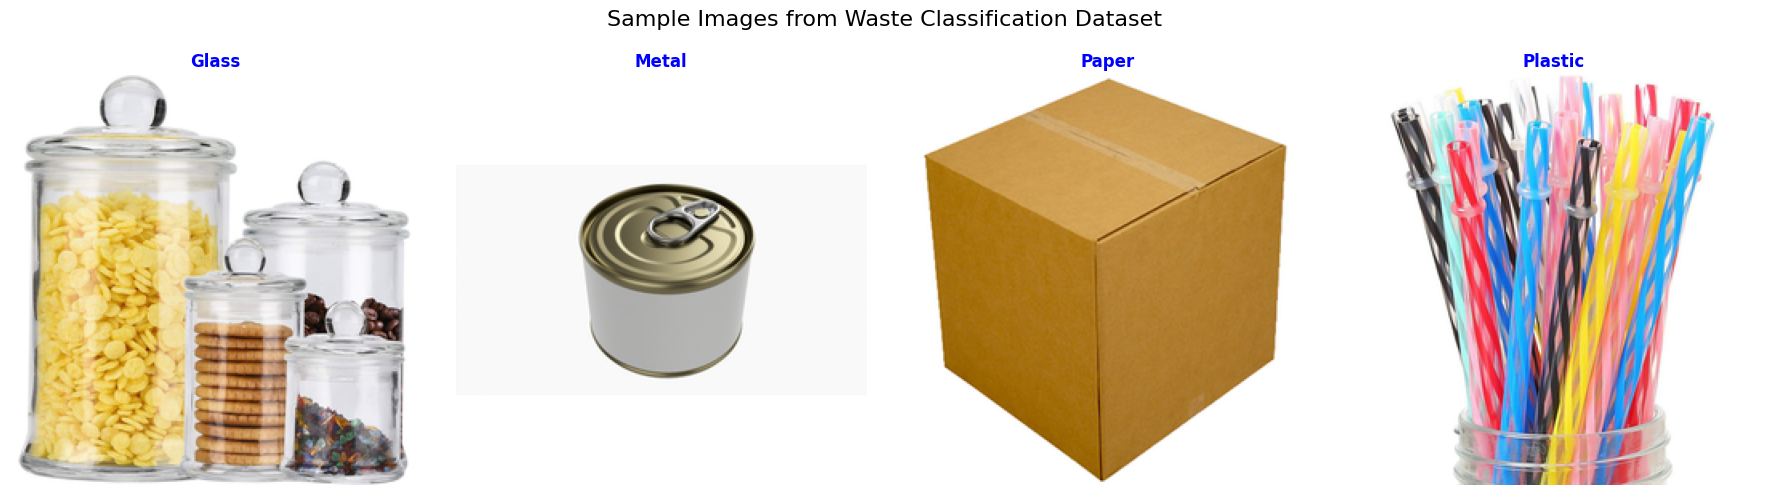


Note: The highlighted categories (Glass, Metal, Paper, Plastic) are the main ones used in the project.


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

dataset_dir = '/home/x/Desktop/cv2/waste_classification'

categories = ['Glass', 'Metal', 'Paper', 'Plastic']
main_categories = ['Glass', 'Metal', 'Paper', 'Plastic']

def get_random_image(category):
    category_path = os.path.join(dataset_dir, 'classes', category)
    
    if not os.path.exists(category_path):
        print(f"Category path not found: {category_path}")
        return None
    
    subfolders = ['default', 'real_world']
    selected_folder = random.choice(subfolders)
    folder_path = os.path.join(category_path, selected_folder)
    
    if not os.path.exists(folder_path):
        print(f"Subfolder not found: {folder_path}")
        return None
    
    try:
        all_images = [file for file in os.listdir(folder_path) 
                      if file.lower().endswith(('.png', '.jpg', '.jpeg')) 
                      and os.path.isfile(os.path.join(folder_path, file))]
        
        if not all_images:
            print(f"No images found in {folder_path}")
            return None
        
        random_image = random.choice(all_images)
        img_path = os.path.join(folder_path, random_image)
        
        print(f"{category} ({selected_folder}): {random_image}")
        
        return img_path
    except Exception as e:
        print(f"Error accessing {folder_path}: {e}")
        return None

fig, axes = plt.subplots(1, len(categories), figsize=(18, 5))

for i, category in enumerate(categories):
    img_path = get_random_image(category)
    
    if img_path:
        try:
            img = Image.open(img_path)
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
                
            axes[i].imshow(img)
            
            title_color = 'black'
            if category in main_categories:
                title_color = 'blue'
                for spine in axes[i].spines.values():
                    spine.set_edgecolor('blue')
                    spine.set_linewidth(3)
            
            axes[i].set_title(category, color=title_color, fontweight='bold' if category in main_categories else 'normal')
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error: {str(e)[:20]}...", 
                         ha='center', va='center', transform=axes[i].transAxes)
    else:
        axes[i].text(0.5, 0.5, f"No image found\nfor {category}", 
                     ha='center', va='center', transform=axes[i].transAxes)
    
    axes[i].axis('off')

plt.suptitle("Sample Images from Waste Classification Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from feature_extraction import FeatureExtractor

os.makedirs("exported_models", exist_ok=True)

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))
base_model = feature_extractor.model

base_model.save("exported_models/feature_extractor_base_model.h5")
print("Saved feature extractor base model to exported_models/feature_extractor_base_model.h5")

print("Generating sample features to calibrate the scaler...")
sample_features = []

for _ in range(20):
    dummy_img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    
    try:
        features = feature_extractor.extract_features(dummy_img)
        features = np.nan_to_num(features)  # Replace NaN values
        sample_features.append(features)
    except Exception as e:
        print(f"Error extracting features: {e}")

if sample_features:
    sample_features = np.array(sample_features)
    print(f"Generated {len(sample_features)} sample feature vectors with shape {sample_features.shape}")
    
    scaler = StandardScaler()
    scaler.fit(sample_features)
    
    with open("exported_models/feature_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Saved feature scaler to exported_models/feature_scaler.pkl")

feature_config = {
    "input_shape": (224, 224, 3),
    "feature_dimensions": sample_features.shape[1] if len(sample_features) > 0 else None,
    "use_deep_features": True,
    "use_color_features": True,
    "use_texture_features": True,
    "use_material_features": True
}

with open("exported_models/feature_config.pkl", "wb") as f:
    pickle.dump(feature_config, f)
print("Saved feature extraction configuration to exported_models/feature_config.pkl")

print("\nExported all components needed for the GUI to accurately replicate the feature extraction pipeline!")

Feature extractor initialized with output shape: (None, 1280)
Saved feature extractor base model to exported_models/feature_extractor_base_model.h5
Generating sample features to calibrate the scaler...
Generated 20 sample feature vectors with shape (20, 1598)
Saved feature scaler to exported_models/feature_scaler.pkl
Saved feature extraction configuration to exported_models/feature_config.pkl

Exported all components needed for the GUI to accurately replicate the feature extraction pipeline!


In [ ]:
#!python3 gui.py